# Regular LSTM with PyTorch

Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from src.models.lstm_vanilla_stateful import LSTMVanillaStateful
from src.losses.acf_losses import EWACFLoss
from sklearn.preprocessing import StandardScaler
device = torch.device("cuda" if not torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

Using device: cpu
Device name: NVIDIA GeForce RTX 4050 Laptop GPU


Import dataset

In [2]:
data = pd.read_csv('../data/raw/exchange_rate.csv')
data = data[['date', '2']]
data = data.rename(columns={'2': 'exchange_rate'})
data

,date,exchange_rate
0,1990/1/1,1.611000
1,1990/1/2,1.610000
2,1990/1/3,1.629300
3,1990/1/4,1.637000
4,1990/1/5,1.653000
...,...,...
7583,2010/10/6,1.222195
7584,2010/10/7,1.223459
7585,2010/10/8,1.234111
7586,2010/10/9,1.233905


Preprocess data

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           7588 non-null   object 
 1   exchange_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [4]:
print("Number of NaN values in the dataset: ", data.isnull().sum())
data.dropna(inplace=True)
data.isnull().sum()

Number of NaN values in the dataset:  date             0
exchange_rate    0
dtype: int64


date             0
exchange_rate    0
dtype: int64

Get non-numeric characters

In [5]:
# data['min_temp'] = data['min_temp'].apply(lambda x: x.replace('?', '-'))

Convert date and string columns to numeric values

In [6]:
data['date'] = pd.to_datetime(data['date'])
# data['min_temp'] = pd.to_numeric(data['min_temp'])

View Dataset

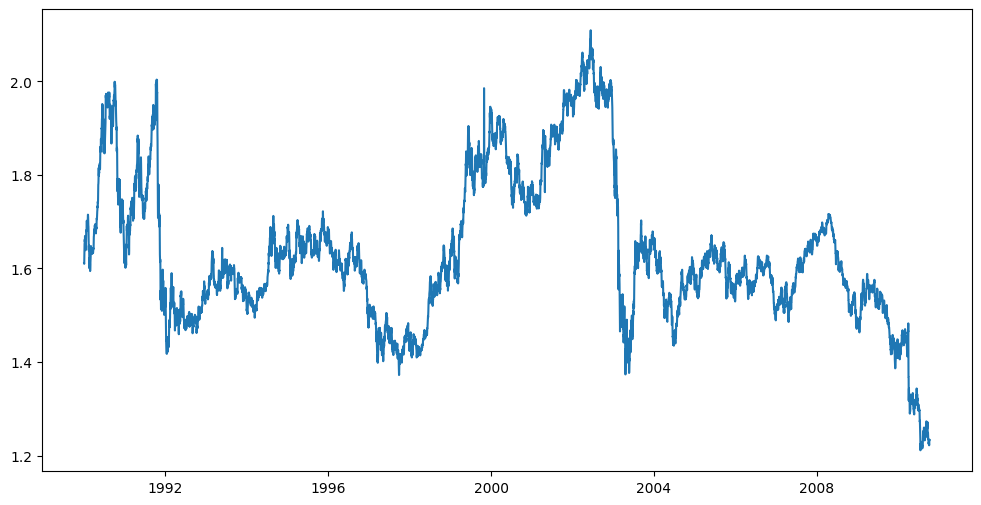

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['exchange_rate'])
plt.show()

### Create Batches Maintaining Temporal Structure

Train/Test Split

In [8]:
# t = np.linspace(0, 100, 2000)
# data = np.sin(0.2*t) + 0.8*np.sin(0.1*t) + 0.1*np.random.randn(len(t))

In [9]:
TRAIN_SIZE = 0.8
time_series = data['exchange_rate'].values

time_series_train = time_series[:int(len(time_series) * TRAIN_SIZE)].reshape(-1, 1)
time_series_test = time_series[int(len(time_series) * TRAIN_SIZE):].reshape(-1, 1)

Normalize the data

In [10]:
scaler = StandardScaler()
time_series_train = scaler.fit_transform(time_series_train)
time_series_test = scaler.transform(time_series_test)

Transform numpy array to tensor

In [11]:
time_series_train = torch.from_numpy(time_series_train).unsqueeze(0).float()
time_series_test = torch.from_numpy(time_series_test).unsqueeze(0).float()

print("--- Tensors After Reshaping (Ready for LSTM) ---")
print("Time Series Train: ", time_series_train.shape)
print("Time Series Test: ", time_series_test.shape)

--- Tensors After Reshaping (Ready for LSTM) ---
Time Series Train:  torch.Size([1, 6070, 1])
Time Series Test:  torch.Size([1, 1518, 1])


Create batch sequences for training

In [12]:
BATCH_SIZE = 40
rounded_length = (time_series_train.shape[1] // BATCH_SIZE) * BATCH_SIZE
full_sequence = time_series_train[0, :rounded_length, :]

sequence_length = len(full_sequence) // BATCH_SIZE
sequences = full_sequence.reshape(BATCH_SIZE, sequence_length, 1)

X_train = torch.from_numpy(np.array(sequences)).float()
X_train.shape

C:\Users\Luis\AppData\Local\Temp\ipykernel_684\3497012082.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X_train = torch.from_numpy(np.array(sequences)).float()


torch.Size([40, 151, 1])

Create batch sequences for testing

In [13]:
rounded_length = time_series_test.shape[1] // BATCH_SIZE * BATCH_SIZE
full_sequence = time_series_test[0, :rounded_length, :]

sequence_length = len(full_sequence)//BATCH_SIZE
sequence = full_sequence.reshape(BATCH_SIZE, sequence_length, 1)

X_test = torch.from_numpy(np.array(sequence)).float()
X_test.shape

C:\Users\Luis\AppData\Local\Temp\ipykernel_684\2986269338.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  X_test = torch.from_numpy(np.array(sequence)).float()


torch.Size([40, 37, 1])

### Train regular LSTM

In [17]:
# More Hyperparameters
EPOCHS = 500
WINDOW_SIZE = 10

model = LSTMVanillaStateful(input_size=X_train.shape[2], hidden_size=16, output_size=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.MSELoss()
acf_loss = EWACFLoss()

start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)
start_event.record()

# Shift the input data by one time step to the right and left
inputs = X_train[:, :-1, :]
targets = X_train[:, 1:, :]

inputs_test = X_test[:, :-1, :]
targets_test = X_test[:, 1:, :]
stream_len = inputs.shape[1]

# Training loop
for epoch in range(EPOCHS):
    model.reset_state()
    model.train()

    train_loss_sum = 0
    train_batch_count = 0
    for i in range(0, inputs.shape[1], WINDOW_SIZE):
        X_batch = inputs[:, i : i + WINDOW_SIZE, :]
        y_batch = targets[:, i : i + WINDOW_SIZE, :]

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss2 = acf_loss(y_pred, y_batch, X_batch)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_loss_sum += loss.item()
        train_batch_count += 1

    avg_train_loss = train_loss_sum / train_batch_count
    
    # Test loop
    model.eval()
    test_loss_sum = 0
    test_batch_count = 0
    with torch.no_grad():
        model.reset_state()

        for i in range(0, X_test.shape[1], WINDOW_SIZE):
            X_batch = inputs_test[:, i : i + WINDOW_SIZE, :]
            y_batch = targets_test[:, i : i + WINDOW_SIZE, :]

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(X_batch)
            test_loss_sum += loss_function(y_pred, y_batch).item()
            test_batch_count += 1

    avg_test_loss = test_loss_sum / test_batch_count
               
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}, Test Loss: {avg_test_loss:.4f}, Train Loss: {avg_train_loss:.4f}')

end_event.record()
torch.cuda.synchronize()

elapsed_time_ms = start_event.elapsed_time(end_event)
elapsed_time_sec = elapsed_time_ms / 1000
minutes = int(elapsed_time_sec // 60)
seconds = int(elapsed_time_sec % 60)

print(f"\nTraining finished in {minutes} minutes and {seconds} seconds.")

Epoch: 10, Test Loss: 1.1138, Train Loss: 0.8120
Epoch: 20, Test Loss: 0.9423, Train Loss: 0.6541
Epoch: 30, Test Loss: 0.7370, Train Loss: 0.4384
Epoch: 40, Test Loss: 0.5309, Train Loss: 0.2367
Epoch: 50, Test Loss: 0.4104, Train Loss: 0.1578
Epoch: 60, Test Loss: 0.3454, Train Loss: 0.1243
Epoch: 70, Test Loss: 0.2938, Train Loss: 0.0959
Epoch: 80, Test Loss: 0.2521, Train Loss: 0.0738
Epoch: 90, Test Loss: 0.2202, Train Loss: 0.0582
Epoch: 100, Test Loss: 0.1959, Train Loss: 0.0474
Epoch: 110, Test Loss: 0.1770, Train Loss: 0.0401
Epoch: 120, Test Loss: 0.1617, Train Loss: 0.0350
Epoch: 130, Test Loss: 0.1493, Train Loss: 0.0314
Epoch: 140, Test Loss: 0.1390, Train Loss: 0.0288
Epoch: 150, Test Loss: 0.1304, Train Loss: 0.0268
Epoch: 160, Test Loss: 0.1231, Train Loss: 0.0252
Epoch: 170, Test Loss: 0.1169, Train Loss: 0.0239
Epoch: 180, Test Loss: 0.1115, Train Loss: 0.0228
Epoch: 190, Test Loss: 0.1068, Train Loss: 0.0219
Epoch: 200, Test Loss: 0.1025, Train Loss: 0.0211
Epoch: 21

Plot the results of the LSTM model

C:\Users\Luis\AppData\Local\Temp\ipykernel_16448\1971212579.py:13: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  predict_plot = scaler.inverse_transform(np.array(y_train.squeeze(0)))
C:\Users\Luis\AppData\Local\Temp\ipykernel_16448\1971212579.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  train_plot = scaler.inverse_transform(np.array(time_series_train.squeeze(0)))
C:\Users\Luis\AppData\Local\Temp\ipykernel_16448\1971212579.py:16: DeprecationWarning: __array__ impleme

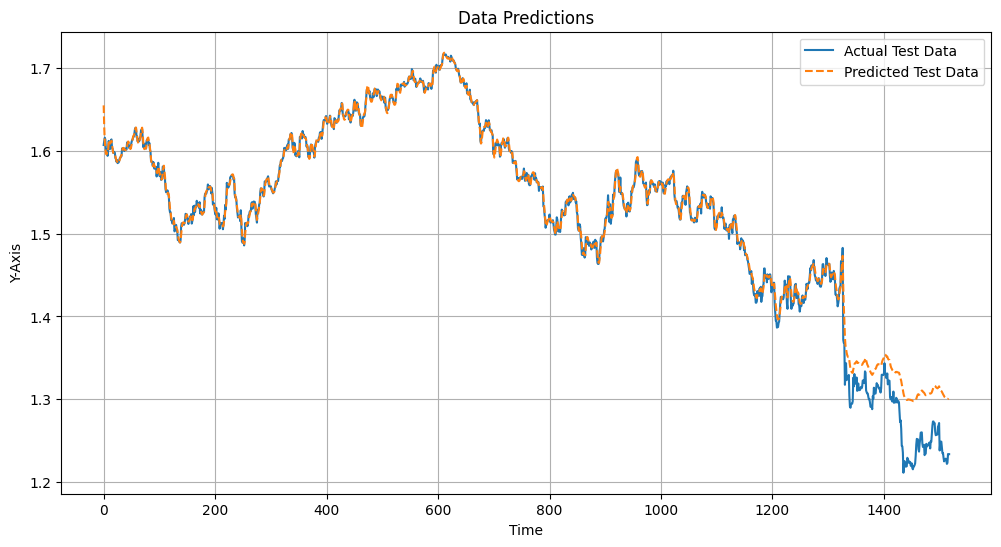

In [ ]:
# Ensure the model is in evaluation mode
model.eval()

full_train = time_series_train[:, :-1, :].to(device)
full_test = time_series_test[:, :-1, :].to(device)
# --- 1. Get Predictions ---
with torch.no_grad():    
    model.reset_state()
    y_train = model(full_train)
    model.reset_state()
    y_test = model(full_test)

predict_plot = scaler.inverse_transform(np.array(y_train.squeeze(0)))
train_plot = scaler.inverse_transform(np.array(time_series_train.squeeze(0)))

predict_test_plot = scaler.inverse_transform(np.array(y_test.squeeze(0)))
test_plot = scaler.inverse_transform(np.array(time_series_test.squeeze(0)))

# # --- 3. Create the Plot ---
plt.figure(figsize=(12, 6))
# plt.plot(range(len(train_plot)), train_plot, label='Actual Train Data')
# plt.plot(range(len(predict_plot)), predict_plot, label='Predicted Train Data')
plt.plot(range(len(test_plot)), test_plot, label='Actual Test Data')
plt.plot(range(len(predict_test_plot)), predict_test_plot, label='Predicted Test Data', linestyle='--')

plt.title('Data Predictions')
plt.xlabel('Time')
plt.ylabel('Y-Axis')
plt.legend()
plt.grid(True)
plt.show()